### Building a simple graph and training a simple GNN 

#### Installations

In [1]:
%pip install -r ../../requirements.txt


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\environ\Scripts\python.exe -m pip install --upgrade pip' command.


#### Imports

In [2]:
import pathlib
import os
import sys
from IPython.display import Image
from py2neo import Graph
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

from utils.general import read_csv, df_to_json, get_year_from_title, remove_year_from_title_str
from utils.movies import insert_movies
from utils.users import insert_ratings
from utils.gnn_simple import GNNEncoder, EdgeDecoder

#### Connecting to the neo4j instance

In [3]:
graph = Graph(
    "bolt://localhost:11005",
    auth=("neo4j", "admin"),
)

#### Storing the movies

##### Simple pre-process of the movies dataframe

In [4]:
movies_df = read_csv("movies")

# split the genres string to a python list
# movies_df["genres"] = movies_df["genres"].map(lambda l: l.split("|"))

# store the movie's year in a separate column
movies_df["year"] = movies_df["title"].map(lambda title: get_year_from_title(title)).astype("string")

# remove the year from the title
movies_df["title"] = movies_df["title"].map(remove_year_from_title_str)

movies_df.head()


Reading from: c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\movies_db\data\movies.csv


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [5]:
# turn the genres list to one-hot vector
# from sklearn.preprocessing import MultiLabelBinarizer

# mlb = MultiLabelBinarizer(sparse_output=True)
# movies_df = movies_df.join(
#     pd.DataFrame.sparse.from_spmatrix(
#         mlb.fit_transform(movies_df.pop('genres')),
#         index=movies_df.index,
#         columns=mlb.classes_
#     )
# )

# movies_df.head()


##### Storing them to neo4j

In [6]:
MOVIES_LIMIT = 300
movies = df_to_json(movies_df)
insert_movies(graph, movies, MOVIES_LIMIT)


#### Storing the users and the ratings

In [7]:
RATINGS_LIMIT = 10000
ratings_df = read_csv("ratings")
ratings = df_to_json(ratings_df)
insert_ratings(graph, ratings, RATINGS_LIMIT)

Reading from: c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\movies_db\data\ratings.csv


#### The Graph

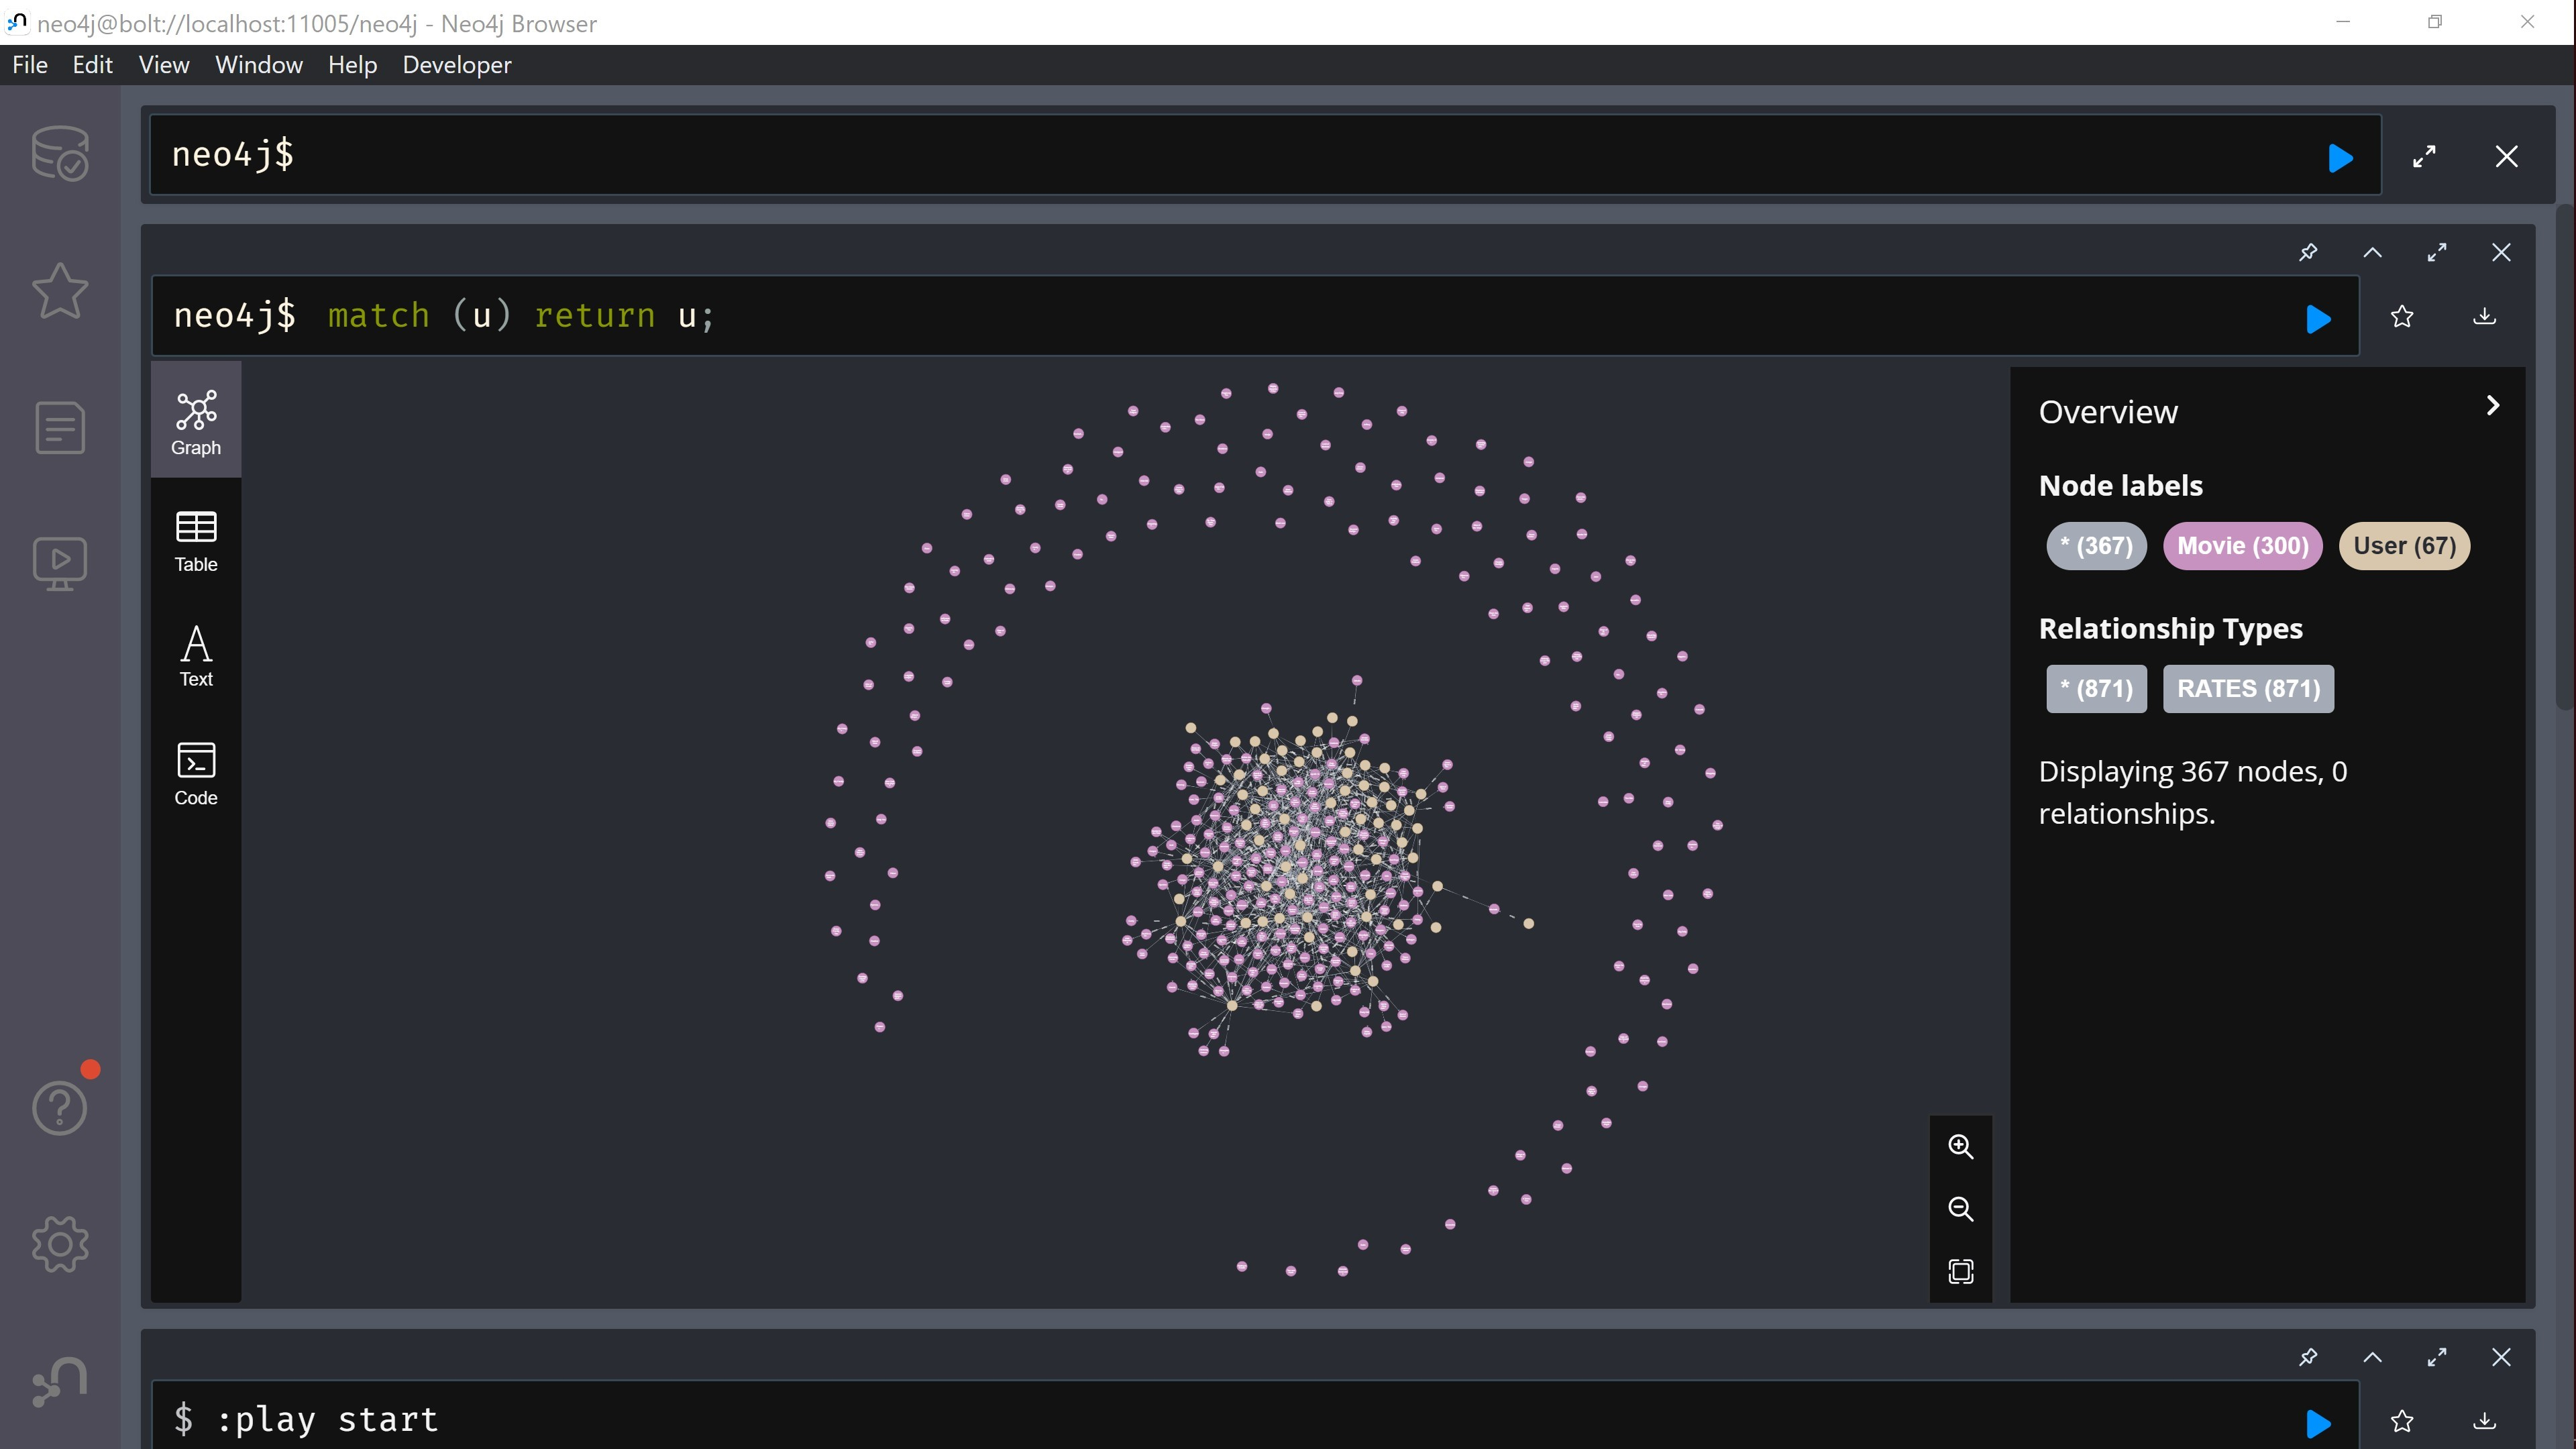

In [8]:
Image(filename='../images/simple_small_graph.jpg')


#### Trying a simple PyG GNN

##### Imports

In [9]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.nn import to_hetero
import torch.nn.functional as F
from utils.pyg import load_node, load_edge, SequenceEncoder, IdentityEncoder, ListEncoder

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


##### Movies nodes

In [11]:
movies_query = """
    MATCH (m: Movie)
    return m.movieId as movieId, m.title as title, m.genres as genres, m.year as year
"""

movies_x, movies_mapping = load_node(
    graph=graph,
    query=movies_query,
    index_col="movieId",
    encoders={
        "title": SequenceEncoder(),
        "genres": ListEncoder(sep="|"),
        "year": SequenceEncoder(),
    }
)


items: dict_items([('title', <utils.pyg.SequenceEncoder object at 0x0000025743BF32B0>), ('genres', <utils.pyg.ListEncoder object at 0x00000254FFA71ED0>), ('year', <utils.pyg.SequenceEncoder object at 0x0000025743BF1F60>)])


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
movies_x.shape

torch.Size([300, 787])

##### Users nodes

In [13]:
users_query = """
    MATCH (u:User)-[r:RATES]-(m:Movie)
    return u.userId as userId, u.username as username, avg(r.rating) as avg_rating, count(r) as ratings;
"""

users_x, users_mapping = load_node(
    graph=graph,
    query=users_query,
    index_col="userId",
    encoders={
        # "avg_rating": IdentityEncoder(dtype=torch.float16),
        # "ratings": IdentityEncoder(dtype=torch.int64),
        "username": SequenceEncoder(),
    }
)


items: dict_items([('username', <utils.pyg.SequenceEncoder object at 0x00000257469E6590>)])


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
users_x.shape

torch.Size([67, 384])

##### Ratings edges

In [15]:
ratings_query = """
    MATCH (u:User)-[r:RATES]-(m:Movie)
    return u.userId as userId, r.rating as rating, r.datetime as datetime, m.movieId as movieId;
"""

edge_index, edge_label = load_edge(
    graph=graph,
    query=ratings_query,
    src_index_col="userId",
    src_mapping=users_mapping,
    dst_index_col="movieId",
    dst_mapping=movies_mapping,
    encoders={
        "rating": IdentityEncoder(dtype=torch.long),
        # "datetime": IdentityEncoder(dtype=torch.long),
    }
)

In [16]:
edge_index.shape

torch.Size([2, 871])

##### Building the dataset

In [17]:
data = HeteroData()

data["user"].x = users_x
data["movie"].x = movies_x

data["user", "reviews", "movie"].edge_index = edge_index
data["user", "reviews", "movie"].edge_label = edge_label
data.to(device, non_blocking=True)
print(data)

HeteroData(
  user={ x=[67, 384] },
  movie={ x=[300, 787] },
  (user, reviews, movie)={
    edge_index=[2, 871],
    edge_label=[871]
  }
)


In [18]:
data = ToUndirected()(data)
del data["movie", "rev_reviews", "user"].edge_label

transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[("user", "reviews", "movie")],
    rev_edge_types=[("movie", "rev_reviews", "user")],
)
train_data, val_data, test_data = transform(data)

In [19]:
train_data

HeteroData(
  user={ x=[67, 384] },
  movie={ x=[300, 787] },
  (user, reviews, movie)={
    edge_index=[2, 697],
    edge_label=[697],
    edge_label_index=[2, 697]
  },
  (movie, rev_reviews, user)={ edge_index=[2, 697] }
)

In [20]:
test_data

HeteroData(
  user={ x=[67, 384] },
  movie={ x=[300, 787] },
  (user, reviews, movie)={
    edge_index=[2, 784],
    edge_label=[87],
    edge_label_index=[2, 87]
  },
  (movie, rev_reviews, user)={ edge_index=[2, 784] }
)

In [21]:
val_data

HeteroData(
  user={ x=[67, 384] },
  movie={ x=[300, 787] },
  (user, reviews, movie)={
    edge_index=[2, 697],
    edge_label=[87],
    edge_label_index=[2, 87]
  },
  (movie, rev_reviews, user)={ edge_index=[2, 697] }
)

#### Balancing the reviews

In [22]:
torch.bincount(edge_label)

tensor([  7,  32,  97, 269, 312, 154])

In [23]:
# We have an unbalanced dataset with many labels for rating 3 and 4, and very
# few for 0 and 1. Therefore we use a weighted MSE loss.

weight = torch.bincount(train_data['user', 'movie'].edge_label)
weight = weight.max() / weight

def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

In [24]:
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [25]:
model = Model(hidden_channels=32).to(device)

# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:

with torch.no_grad():
    model.encoder(train_data.collect('x'), train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [26]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.collect('x'), train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

In [27]:
@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.collect('x'), data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [31]:
for epoch in range(1, 1000):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    if not epoch%100:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

Epoch: 100, Loss: 0.3778, Train: 0.4959, Val: 1.3531, Test: 1.2853
Epoch: 200, Loss: 0.2640, Train: 0.4129, Val: 1.2822, Test: 1.2869
Epoch: 300, Loss: 0.2352, Train: 0.3869, Val: 1.2835, Test: 1.3125
Epoch: 400, Loss: 0.2068, Train: 0.3625, Val: 1.2992, Test: 1.3471
Epoch: 500, Loss: 0.1870, Train: 0.3406, Val: 1.3621, Test: 1.3306
Epoch: 600, Loss: 0.1434, Train: 0.3070, Val: 1.4029, Test: 1.3376
Epoch: 700, Loss: 0.1375, Train: 0.2955, Val: 1.4094, Test: 1.3102
Epoch: 800, Loss: 0.1404, Train: 0.3009, Val: 1.4434, Test: 1.3213
Epoch: 900, Loss: 0.1196, Train: 0.2791, Val: 1.4449, Test: 1.2894
